In [533]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [534]:
def f(x):
  return 3*x**2 - 4*x + 5

In [535]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


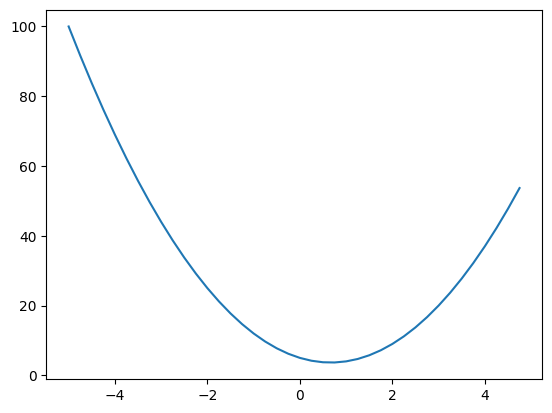

In [536]:
xs = np.arange(-5 , 5 , 0.25)
ys = f(xs)
print(xs)
ys

plt.plot(xs , ys)

In [537]:
# derivative of a simple input to the function
def df(x):
  return 6*x - 4
# print(df(xs))
# this is the derivative using maths but we cannot use proper derivative by hand for our neural networks
# so we use basic calculus for differentiation of function

h = 0.001
x = 3.0
print((f(x + h) - f(x)) / h )# --> this is the slope/derivative
print(df(3.0))

# this is the derivative of a function wrt to one inputa

14.00300000000243
14.0


In [538]:
# this is the derivative of function with multiple inputs
a = 2.0
b=-3.0
c = 10

d = a*b + c
print(d)

# now for derivatives
h = 0.0001

# derivative wrt 'a'
'''
a+=h
d1 = a*b + c
print(d1)
print('slope/derivative --> ' , (d1-d)/h)'''

# derivative wrt 'b'
'''
b+=h
d2 = a*b + c
print(d2)
print('slope/derivative --> ' , (d2-d)/h)
'''

c+=h
d3 = a*b + c
print(d3)
print('slope/derivative --> ' , (d3-d)/h)


4.0
4.0001
slope/derivative -->  0.9999999999976694


In [539]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg' , graph_attr={'rankdir': 'LR'}) # LR --> left to right

  nodes , edges = trace(root)
  for n in nodes:
    dot.node(name=str(id(n)) , label="{%s | data %.4f | grad %.4f}" % (n._label , n.data , n.grad) , shape='record')

    if n._opr:
      dot.node(name=str(id(n)) + n._opr , label=n._opr)
      dot.edge(str(id(n)) + n._opr , str(id(n)))

  for n1,n2 in edges:
    dot.edge(str(id(n1)) , str(id(n2)) + n2._opr)

  return dot

In [540]:
# now for neural networks we do very complex maths so we need data structure to maintain this expressions
class Value:
  def __init__(self , data , _children=() , _opr = "" , _label = ''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._opr = _opr
    self._label = _label
    self._backward = lambda : None

  def __repr__(self) -> str:
    return f"value data = {self.data}"

  def __add__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data + other.data , (self , other) , "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  __radd__ = __add__

  def __mul__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data * other.data, (self , other) , '*')

    def _backward():
      self.grad += (other.data)*out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other - 1)) * out.grad

    out._backward = _backward
    return out


  def __neg__(self):
      return self * -1

  def __rsub__(self, other):
      return Value(other) - self


  def __truediv__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data / other.data, (self , other) , "/")
    return out

  def __sub__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data - other.data, (self , other) , '-')

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += -1.0 * out.grad
    out._backward = _backward
    return out


  def __rmul__(self , other): # other*self
    return self*other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t , (self ,) , 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)

          topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

# self refers to the Value object on the left side of the operator, and other refers to the Value object on the right side.

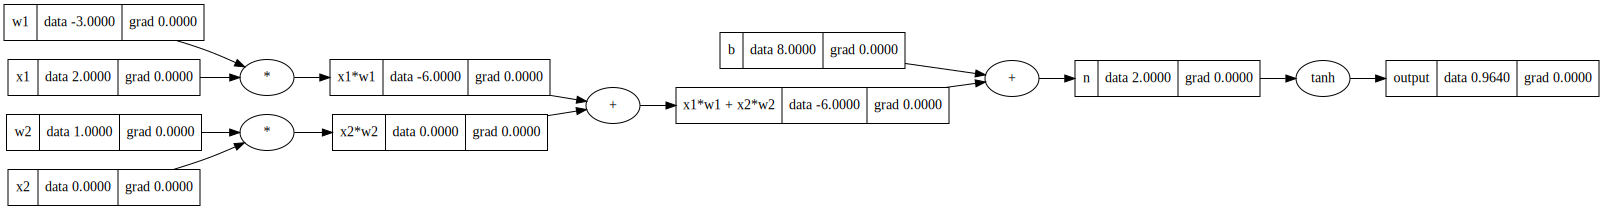

In [541]:
# inputs
x1 = Value(2.0 , _label='x1')
x2 = Value(0.0 , _label='x2')
# weights
w1 = Value(-3.0 , _label='w1')
w2 = Value(1.0 , _label='w2')
# bias
b = Value(8 , _label='b')

x1w1 = x1*w1 ; x1w1._label = 'x1*w1'
x2w2 = x2*w2 ; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n._label = 'n'
o = n.tanh() ; o._label = 'output'
draw_dot(o)

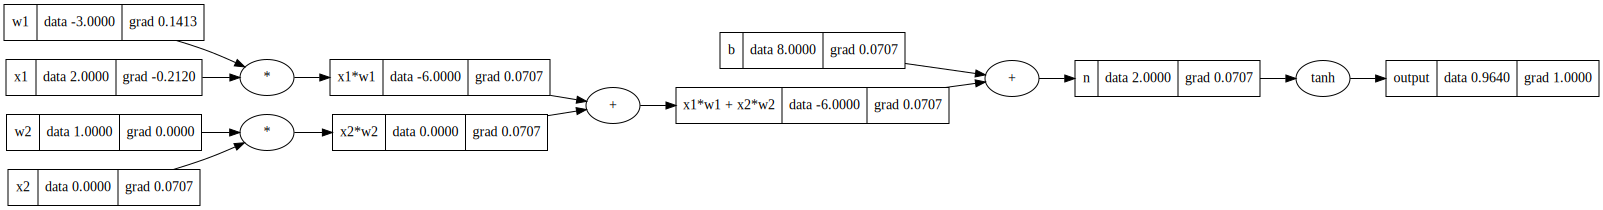

In [542]:
o.backward()
draw_dot(o)

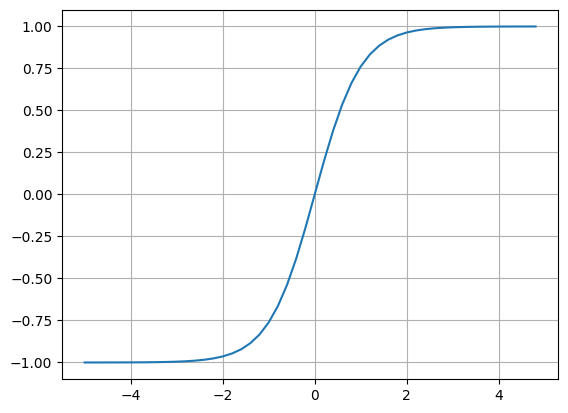

In [543]:
# tanh activation function
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2))) ; plt.grid()

In [544]:
a = Value(10.0)
a+1

value data = 11.0

In [545]:
import torch

x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True

b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('-----------------------')
print('x1' , x1.grad.item())
print('w1' , w1.grad.item())
print('x2' , x2.grad.item())
print('w2' , w2.grad.item())

0.7071066904050358
-----------------------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


# Building a neural net library --> multi layer preceptron

In [546]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self , X):
    # w*x + b
    out = sum((wi*xi for wi , xi in zip(self.w , X)) , self.b)
    out = out.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

X = [2,3]
n = Neuron(2)
n(X)

value data = -0.6285821756532824

# Now we create layers of neurons

In [547]:
class Layer:
  def __init__(self , nin , nout): # no. neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self , X):
    out = [n(X) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

X = [2,3]
l = Layer(2,3)
l(X)

[value data = -0.9830650962579548,
 value data = -0.9747816387326791,
 value data = 0.9110122757296008]

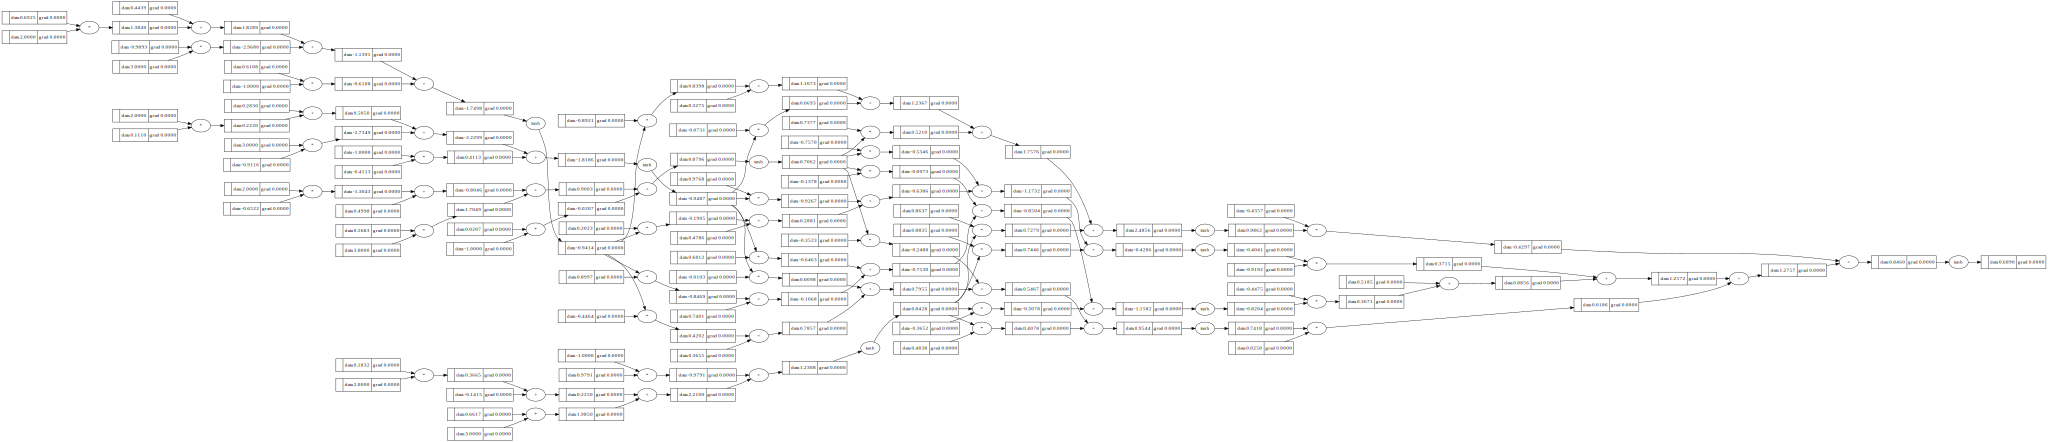

In [548]:
class MLP:
  def __init__(self , nin ,nouts): # now we take nouts as a list of sizes of layers that we want in our mlp
    sz = [nin] + nouts
    self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

  def __call__(self , X):
    for layer in self.layers:
      X = layer(X)
    return X

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


X = [2,3,-1]
mlp = MLP(3 , [4,4,1]) # --> [4,4,1] means 4 neuron two hidden layer and 1 in output layer (we do not include the input layer)
mlp(X)

draw_dot(mlp(X))

In [549]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, 1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])

ypred = [mlp(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt , yout in zip(ys , ypred))
loss.backward()

for p in mlp.parameters():
  print(p.data , p.grad)
  p.data += -0.01 * p.grad
  print(p.data)

print(loss.data)

0.8205468158321687 0.013830319360636553
0.8204085126385623
0.6494446304327077 -0.014550970081367381
0.6495901401335215
-0.2603614900224256 -0.10158767880638347
-0.2593456132343618
0.28105630787571956 -0.015143841636198425
0.28120774629208156
0.8038974159848604 1.0572693772193138
0.7933247222126673
-0.340974799463275 1.2865932984398136
-0.35384073244767317
-0.19201332104154778 -0.7805904407254733
-0.18420741663429305
-0.9949819565494491 0.7304110520439334
-1.0022860670698885
-0.47837765319019 1.2514798377007914
-0.4908924515671979
-0.07302033169844835 1.5134029068189103
-0.08815436076663745
0.039426531104785 -0.834761151311129
0.047774142617896295
0.7197900063390372 0.9790778516934527
0.7099992278221027
0.44482348031743757 0.8788789328265719
0.43603469098917186
-0.8881916915139636 0.8552491570889423
-0.896744183084853
0.9276101212073304 -1.0405870503471513
0.938015991710802
0.6459329180418178 0.7666356597018409
0.6382665614447994
-0.2919785582633776 -0.48171908919584605
-0.2871613673714

In [550]:
ypred

[value data = 0.36073606465236435,
 value data = -0.8544062413401807,
 value data = -0.6386423933119365,
 value data = -0.018282146047208195]

In [553]:
for k in range(20):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward propagation
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent
    for p in mlp.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.03704542144559326
1 0.03516175017815714
2 0.0334564630221321
3 0.031905689995169885
4 0.03048959915472313
5 0.029191583346397557
6 0.027997634776893057
7 0.026895858916857224
8 0.02587609298180453
9 0.024929603766076447
10 0.024048846300826487
11 0.023227269574137264
12 0.022459158986055293
13 0.02173950771375007
14 0.021063911004327494
15 0.020428478782510712
16 0.019829762988094267
17 0.019264696835862453
18 0.018730543784126877
19 0.01822485445435792


In [554]:
ypred

[value data = 0.9478059765338126,
 value data = -0.9642073984712257,
 value data = -0.9176166443308598,
 value data = 0.9137879895068945]